In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/repos/ProactiveHRI.jl`


In [ ]:
Pkg.update()
Pkg.instantiate()

In [30]:
include("dynamics.jl")
include("planner.jl")
include("planner_utils.jl")
include("utils.jl")
include("plotting.jl")
include("mpc.jl")
include("sim.jl")
include("experiments.jl")

evaluate_sim (generic function with 1 method)

### Interaction planner

In [3]:
dt = 0.1
velocity_max = 3.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [pi, 2.])
human = Unicycle(dt, velocity_max, [1., 3.])

time_horizon = 25
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
Q = diagm([0.0; 0.0; 0.])
R = diagm([1.0; 0.1]) 
Qt = diagm([10.; 10.; 0.])
markup = 1.05
collision_slack = 150.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.01]
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)


PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.05
  collision_slack: Float64 150.0
  collision_markup: Float64 0.98
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [4]:
robot_initial_state = [5.; 5.; -pi / 2.; 0.]
robot_goal_state = [5.; -5.; -pi / 2; 0.]
human_initial_state = [5.; -5.; pi / 2]
human_goal_state = [5.; 5.; pi / 2]
solver = "ECOS"

ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
# 
# ip = InteractionPlanner(human_hps, 
#                         robot_hps,
#                         human_initial_state,
#                         robot_initial_state,
#                         human_goal_state,
#                         robot_goal_state,
#                         solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [ ]:
# Adds a wall constraint to the planner
wall_1 = Wall("x", 0., 6.1, "less")
wall_constraint(ip, wall_1, "wall_1")
wall_2 = Wall("x", 0.1, 3.2, "greater")
wall_constraint(ip, wall_2, "wall_2")

In [5]:
incon_problem, xs, us = @time solve(ip.ego_planner.incon, iterations=10, verbose=false, keep_history=false)
incon_problem, xs, us = @time solve(ip.other_planner.incon, iterations=10, verbose=false, keep_history=false);



  0.417640 seconds (668.54 k allocations: 57.097 MiB, 7.24% gc time, 69.19% compilation time)


  0.105104 seconds (404.11 k allocations: 36.182 MiB, 22.75% gc time)


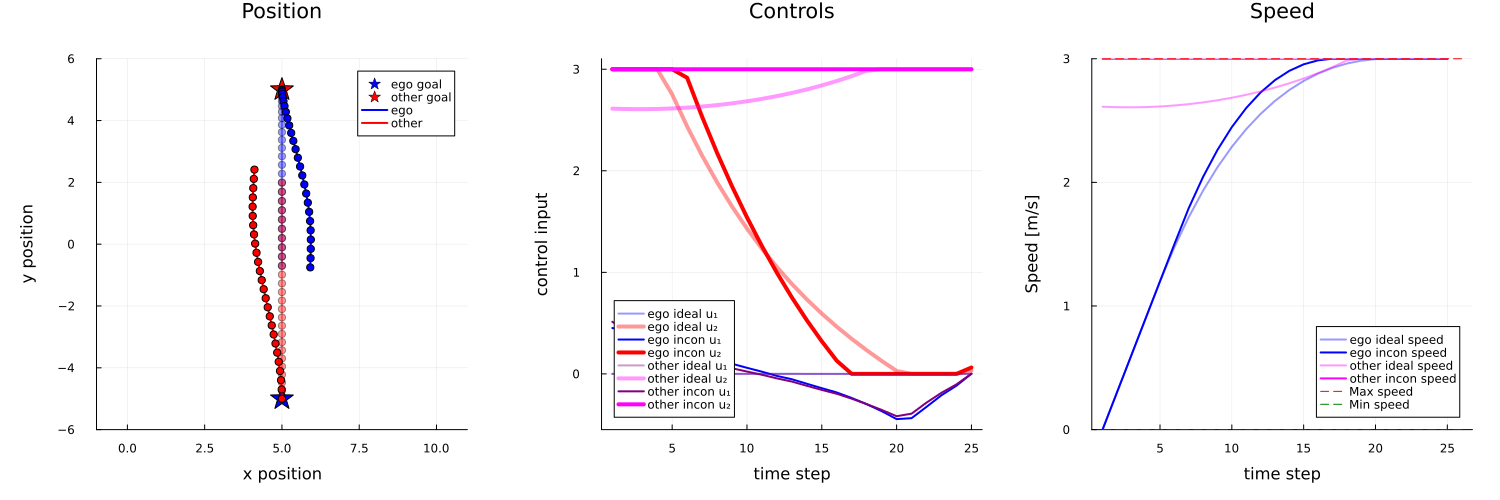

In [6]:
plot_solve_solution(ip, walls=nothing, pos_xlims=[-1, 11], pos_ylims=[-6, 6])

# Iterated Best Response

In [7]:
@time ibr(ip, 3, "ego")

  0.052813 seconds (260.46 k allocations: 23.304 MiB)


InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


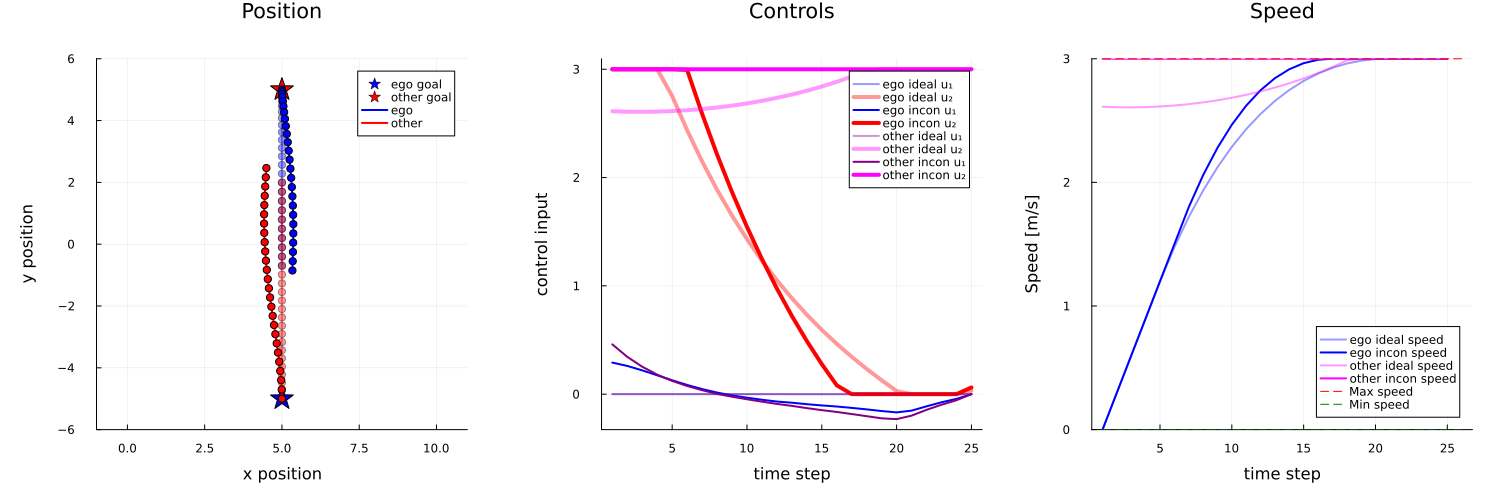

In [8]:
plot_solve_solution(ip, pos_xlims=[-1, 11], walls=nothing, pos_ylims=[-6, 6])

# Animation

┌ Info: Saved animation to /tmp/jl_x69c7gfkhU.gif
└ @ Plots /home/jasper/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_x69c7gfkhU.gif")
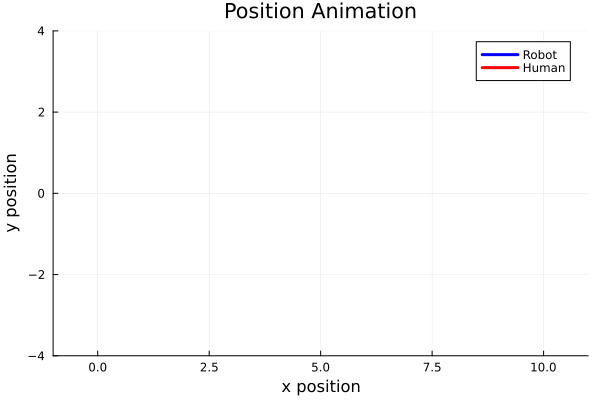

In [9]:
animation(ip, pos_xlims=[-1, 11], pos_ylims=[-4, 4])

┌ Info: Saved animation to /tmp/jl_JqZA1SVcRE.gif
└ @ Plots /home/jasper/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_JqZA1SVcRE.gif")
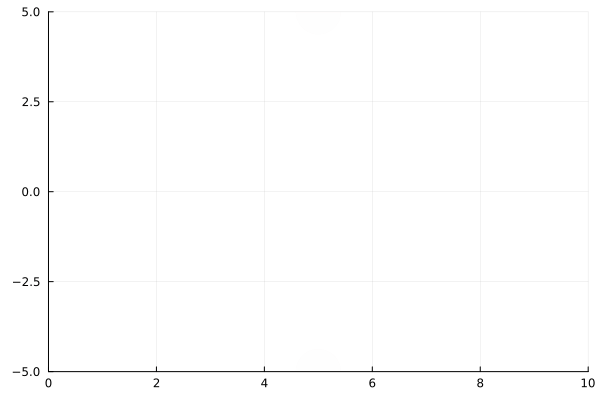

In [10]:
avoidance_animation(ip, pos_xlims=[0, 10], pos_ylims=[-5, 5])

# MPC Controller Simulation
*At the moment it is a known issue that the sim breaks if the dynamics classes used are different between the different InteractionPlanner models, will be fixed

In [11]:
include("sim.jl")
include("mpc.jl")

mpc_step (generic function with 2 methods)

In [105]:
solver = "ECOS"

time_horizon = 25
dt = 0.1
velocity_max = 1.5

human = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 1.5])

Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])
markup = 1.05
collision_slack = 150.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.1]
collision_radius = 1.
inconvenience_ratio = 0.2

human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 1.5

robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 1.5])

Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)

PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.05
  collision_slack: Float64 150.0
  collision_markup: Float64 0.98
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [106]:
robot_initial_state = [0.; 0.; 0.; 2.]
robot_goal_state = [10.; 0.; 0.; 2.]
human_initial_state = [10.; 0.; pi; 2.]
human_goal_state = [0.; 0.; pi; 2.]

robot_ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)


InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [107]:
dt = 0.1
velocity_max = 1.5
# human = SingleIntegratorPolar2D(dt, velocity_max, [3 * pi / 2, 2.])
# human = Unicycle(dt, velocity_max, [0.5, 3.])
human = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 1.5])

time_horizon = 25
#SingleIntegratorPolar2D
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
# unicycle
# Q = diagm([0.0; 0.0; 0.])
# R = diagm([1.0; .1]) 
# Qt = diagm([10.; 10.; 0.])
# dynamicalyl extended unicycle
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 0.0]) 
Qt = diagm([10.; 10.; 0.; 0.])
markup = 1.05
collision_slack = 150.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.1]
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 1.5
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 1.5])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 0.0]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)

PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 0.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.05
  collision_slack: Float64 150.0
  collision_markup: Float64 0.98
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [108]:
human_ip = InteractionPlanner(human_hps, 
                        robot_hps,
                        human_initial_state,
                        robot_initial_state,
                        human_goal_state,
                        robot_goal_state,
                        solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [109]:
robot_path, robot_controls, human_path, human_controls = simulate(robot_ip, human_ip, 50, leader="ego")

([0.0 0.0 0.0 2.0; 0.19244590174442788 0.0 0.0004498369333120619 1.8489180348885577; … ; 7.329059070421081 0.2546819583185684 -0.10478650201715901 1.4121891721846884; 7.468380942429407 0.24013301989660155 -0.10330885702886067 1.3894003194677749], [0.004498369333120619 -1.510819651114424; -0.005116465749546655 -1.360295821491403; … ; 0.016590726805958363 -0.20382441847077626; 0.01477644988298339 -0.22788852716913552], [10.0 0.0 3.141592653589793 2.0; 9.807291763291714 2.3599952525413253e-17 3.1417592366059974 1.8541647341657133; … ; 2.6397667741135944 -0.31630916638859863 3.0333429963969794 1.4172882170111893; 2.5000327349994325 -0.3010046312526684 3.031654981660842 1.3941054000211892], [0.0016658301620441167 -1.4583526583428676; 0.000467553661799488 -1.3752438669381228; … ; -0.018903245676345562 -0.2080415905112781; -0.016880147361375532 -0.23182816990000027])

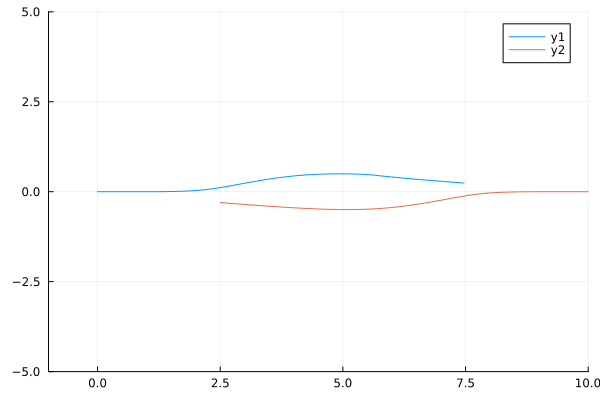

In [110]:
plt = plot(robot_path[:,1], robot_path[:,2], xlims=[-1, 10], ylims=[-5, 5])
plot!(plt, human_path[:,1], human_path[:,2])

┌ Info: Saved animation to /tmp/jl_BwVuR6xEDq.gif
└ @ Plots /home/jasper/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_BwVuR6xEDq.gif")
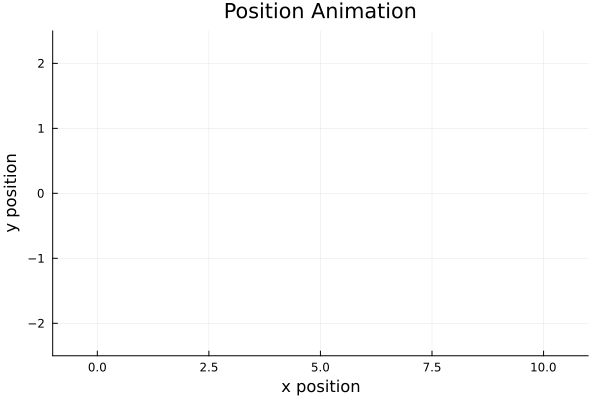

In [111]:
animation(robot_path, human_path, pos_xlims=[-1, 11], pos_ylims=[-2.5, 2.5])

# Summary Plots

### Setup the planner

In [61]:
dt = 0.1
velocity_max = 1.5
# human = SingleIntegratorPolar2D(dt, velocity_max, [pi, 2.])
human = Unicycle(dt, velocity_max, [1., 1.5])

time_horizon = 50
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
Q = diagm([0.0; 0.0; 0.])
R = diagm([1.0; 0.0]) 
Qt = diagm([10.; 10.; 0.])
markup = 0.8
collision_slack = 150.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.01]
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 1.5
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)


PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 50
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 0.8
  collision_slack: Float64 150.0
  collision_markup: Float64 0.98
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [62]:
robot_initial_state = [0.; 0.; 0.; 0.]
robot_goal_state = [10.; 0.; 0.; 0.]
human_initial_state = [10.; 0.; pi]
human_goal_state = [0.; 0.; pi]
solver = "ECOS"

ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [63]:
incon_problem, xs, us = @time solve(ip.ego_planner.incon, iterations=10, verbose=false, keep_history=false)
incon_problem, xs, us = @time solve(ip.other_planner.incon, iterations=10, verbose=false, keep_history=false);

  0.221529 seconds (846.32 k allocations: 84.971 MiB, 16.13% gc time)


  0.240431 seconds (783.68 k allocations: 77.830 MiB, 9.53% gc time)


In [64]:
@time saved_data_test, _, _, _, _ = ibr_save(ip, 2, "ego")

  0.149136 seconds (422.80 k allocations: 39.849 MiB, 9.94% gc time)


(SaveData
  previous_ips: Array{InteractionPlanner}((2,))
, [[2.2588376264506443e-10 2.0884023907676943e-10 5.00102180972525e-11 2.8897356327775966e-10; 0.00927451553768871 7.506154477190308e-5 0.012173317451156927 0.18549708047153182; … ; 6.620222397495439 0.5972308156318794 -0.19918636459435501 1.4999993547793233; 6.769434941989797 0.5672824669460691 -0.19690448320742687 1.5425513239957684], [-2.1644868432915282e-10 -1.7963225666386935e-10 -5.1496300804626984e-11 -2.3062259646893588e-10; 0.00954615974310258 8.143565166166668e-5 0.012814062681163644 0.19093100032662993; … ; 6.662310757803781 0.5296894399670138 -0.17366652733372387 1.4999997065655926; 6.812383659195453 0.5035330661624549 -0.1713962902827606 1.5457170254109989]], [[0.12173317352934085 1.8549707969885307; 0.12842253358892033 1.923256894109809; … ; 0.027051132427972503 3.1996516666363427e-6; 0.02281881394441794 0.4255196921258248], [0.128140627825768 1.9093100089966315; 0.13645897390075598 1.9795320658163602; … ; 0.029770

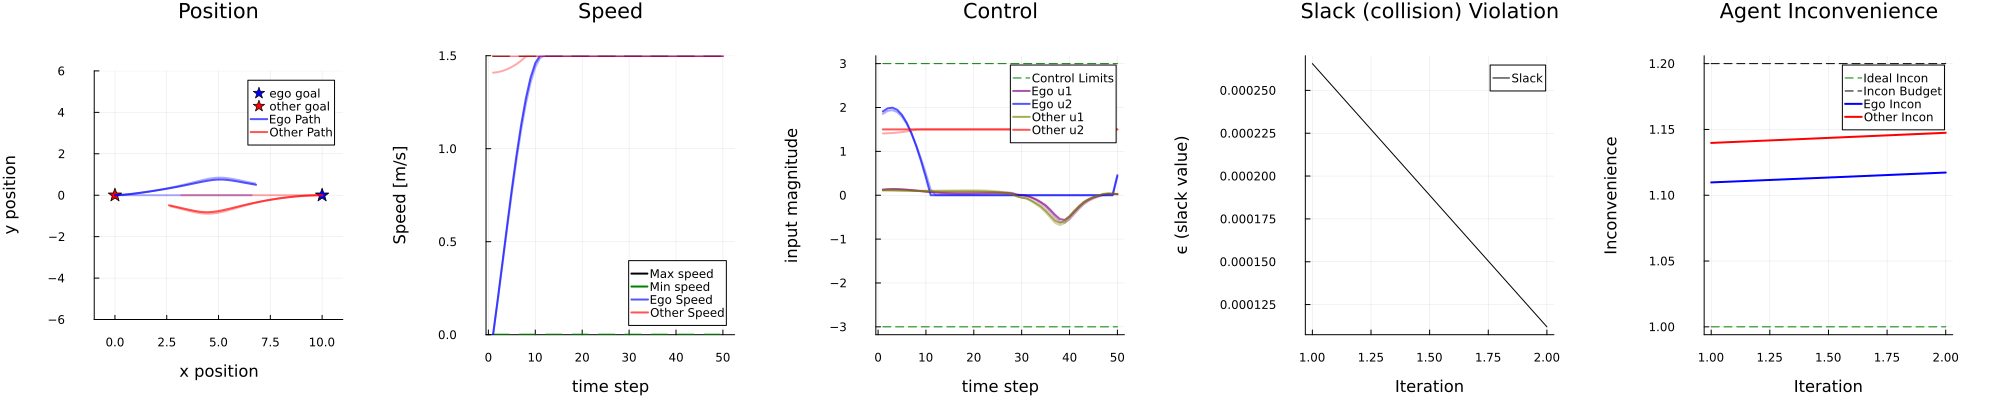

In [65]:
plot_example = plot_solve_solution(saved_data_test, scatter=false, show_speed=true, show_control=true)

In [25]:
function plot_solve_solution(problem::SaveData, second_problem::SaveData,show_theta::Bool; pos_xlims=[-1,11], pos_ylims=[-6, 6], scatter=true::Bool, show_speed=true::Bool, show_control=true::Bool)

    l = @layout [a b] 
    width=2000
    height=800
    alpha_plot = 0.7
    linewidth = 2
    markersize = 2
    markersize_large = 7
    ego_color = :blue
    other_color = :red

    global iterations = length(problem.previous_ips)

    alpha_ratio = 1 / (iterations + 1)
    N = problem.previous_ips[1].ego_planner.ideal.hps.time_horizon

    ego_goal_state = problem.previous_ips[1].ego_planner.ideal.opt_params.goal_state
    other_goal_state = problem.previous_ips[1].other_planner.ideal.opt_params.goal_state

    ego_dynamics = problem.previous_ips[1].ego_planner.ideal.hps.dynamics       # use first ip arbitrarily, any iteration will give the same values for these entries
    other_dynamics = problem.previous_ips[1].other_planner.ideal.hps.dynamics

    global ego_ctrl_dim = 2
    global other_ctrl_dim = 2

    # plotting position trajectory

    plot_traj = plot(size=(height, height), xlabel="x position", ylabel="y position", title="Position", margin=10mm, ylims=pos_ylims, xlims=pos_xlims, aspect_ratio=:equal)
    scatter!(ego_goal_state[1:1], ego_goal_state[2:2], marker=:star, markersize=markersize_large, color=ego_color, label="ego goal")
    scatter!(plot_traj, other_goal_state[1:1], other_goal_state[2:2], marker=:star, markersize=markersize_large, color=other_color, label="other goal")

    plot!(plot_traj, value.(problem.previous_ips[end].ego_planner.incon.model[:x])[:,1], value.(problem.previous_ips[end].ego_planner.incon.model[:x])[:,2], color=ego_color, linewidth=linewidth, label="Robot μ = 0.9", alpha=alpha_plot)

    plot!(plot_traj, value.(problem.previous_ips[end].other_planner.incon.model[:x])[:,1], value.(problem.previous_ips[end].other_planner.incon.model[:x])[:,2], color=other_color, linewidth=linewidth, label="Human μ = 0.9", alpha=alpha_plot)


    plot!(plot_traj, value.(second_problem.previous_ips[end].ego_planner.incon.model[:x])[:,1], value.(second_problem.previous_ips[end].ego_planner.incon.model[:x])[:,2], color=:purple, linewidth=linewidth, label="Robot μ = 1.1", alpha=alpha_plot)

    plot!(plot_traj, value.(second_problem.previous_ips[end].other_planner.incon.model[:x])[:,1], value.(second_problem.previous_ips[end].other_planner.incon.model[:x])[:,2], color=:green, linewidth=linewidth, label="Human μ = 1.1", alpha=alpha_plot)

    if scatter
        scatter!(plot_traj, value.(problem.previous_ips[end].ego_planner.ideal.model[:x])[:,1], value.(problem.previous_ips[end].ego_planner.ideal.model[:x])[:,2], color=ego_color, linewidth=linewidth, label="", alpha=alpha_plot)

        scatter!(plot_traj, value.(problem.previous_ips[end].other_planner.ideal.model[:x])[:,1], value.(problem.previous_ips[end].other_planner.ideal.model[:x])[:,2], color=other_color, linewidth=linewidth, label="", alpha=alpha_plot)

        scatter!(plot_traj, value.(second_problem.previous_ips[end].ego_planner.ideal.model[:x])[:,1], value.(second_problem.previous_ips[end].ego_planner.ideal.model[:x])[:,2], color=ego_color, linewidth=linewidth, label="", alpha=alpha_plot)

        scatter!(plot_traj, value.(second_problem.previous_ips[end].other_planner.ideal.model[:x])[:,1], value.(second_problem.previous_ips[end].other_planner.ideal.model[:x])[:,2], color=other_color, linewidth=linewidth, label="", alpha=alpha_plot)
    end
    # plotting speed/control

    # speed parameters
    max_speed = maximum([problem.previous_ips[1].ego_planner.ideal.hps.dynamics.velocity_max, problem.previous_ips[1].other_planner.ideal.hps.dynamics.velocity_max])
    ego_max_speed = problem.previous_ips[1].ego_planner.ideal.hps.dynamics.velocity_max
    other_max_speed = problem.previous_ips[1].other_planner.ideal.hps.dynamics.velocity_max

    # control parameters
    ego_ctrl_dim = problem.previous_ips[1].ego_planner.ideal.hps.dynamics.ctrl_dim
    other_ctrl_dim = problem.previous_ips[1].other_planner.ideal.hps.dynamics.ctrl_dim

    ego_max_ctrl = maximum(problem.previous_ips[1].ego_planner.ideal.hps.dynamics.control_max)
    ego_min_ctrl = minimum(problem.previous_ips[1].ego_planner.ideal.hps.dynamics.control_min)
    other_max_ctrl = maximum(problem.previous_ips[1].other_planner.ideal.hps.dynamics.control_max)
    other_min_ctrl = minimum(problem.previous_ips[1].other_planner.ideal.hps.dynamics.control_min)

    plot_theta = plot(size=(height, height), xlabel="time step", ylabel="abs(Theta)", title="Theta vs. time", margin=10mm, legend=:bottomright)
    plot_ctrl = plot(size=(height, height), xlabel="time step", ylabel="input magnitude", title="Control", margin=10mm)

    # angle plotting
    robot_xs_mu_09 = vector_of_vectors_to_matrix(problem.previous_ips[iterations].ego_planner.incon.opt_params.previous_states)
    human_xs_mu_09 = vector_of_vectors_to_matrix(problem.previous_ips[iterations].other_planner.incon.opt_params.previous_states)
    robot_xs_mu_11 = vector_of_vectors_to_matrix(second_problem.previous_ips[iterations].ego_planner.incon.opt_params.previous_states)
    human_xs_mu_11 = vector_of_vectors_to_matrix(second_problem.previous_ips[iterations].other_planner.incon.opt_params.previous_states)
    plot!(plot_theta, robot_xs_mu_09[:,3:3], linewidth=2, label="Robot μ = 0.9", color=ego_color)
    plot!(plot_theta, human_xs_mu_09[:,3:3], linewidth=2, label="Human μ = 0.9", color=other_color)
    plot!(plot_theta, robot_xs_mu_11[:,3:3], linewidth=2, label="Robot μ = 1.1", color=:magenta)
    plot!(plot_theta, human_xs_mu_11[:,3:3], linewidth=2, label="Human μ = 1.1", color=:green)

        # ctrl plotting
    plot!(plot_ctrl, 1:N, maximum([ego_max_ctrl, other_max_ctrl]) * ones(Float64, N), linestyle=:dash, linewith=linewidth,  color=:green, label="Control Limits")
    plot!(plot_ctrl, 1:N, minimum([ego_min_ctrl, other_min_ctrl]) * ones(Float64, N), linestyle=:dash, linewith=linewidth,  color=:green, label="")   
        # ego plot
    for j in 1:ego_ctrl_dim
        plot!(plot_ctrl, 1:N, vector_of_vectors_to_matrix(problem.previous_ips[iterations].ego_planner.incon.opt_params.previous_controls)[:, j], label="", color=RGB(1 - (1 / ego_ctrl_dim) * j, 0., (1 / ego_ctrl_dim) * j), linewidth=linewidth, alpha=(i * alpha_ratio))
        plot!(plot_ctrl, 1:N, vector_of_vectors_to_matrix(second_problem.previous_ips[iterations].ego_planner.incon.opt_params.previous_controls)[:, j], label="", color=RGB(1 - (1 / ego_ctrl_dim) * j, 0., (1 / ego_ctrl_dim) * j), linewidth=linewidth, alpha=(i * alpha_ratio))
    end 
        # other plot
    for k in 1:other_ctrl_dim
        plot!(plot_ctrl, 1:N, vector_of_vectors_to_matrix(problem.previous_ips[iterations].other_planner.incon.opt_params.previous_controls)[:, k], label="", color=RGB((1 / other_ctrl_dim) * k, 1 - (1 / other_ctrl_dim) * k, 0.), linewidth=linewidth, alpha=(i * alpha_ratio))
        plot!(plot_ctrl, 1:N, vector_of_vectors_to_matrix(second_problem.previous_ips[iterations].other_planner.incon.opt_params.previous_controls)[:, k], label="", color=RGB((1 / other_ctrl_dim) * k, 1 - (1 / other_ctrl_dim) * k, 0.), linewidth=linewidth, alpha=(i * alpha_ratio))
    end 


    slack_violation = Vector{Float64}(undef, iterations)

    for i in 1:iterations
        slack_violation[i] = value(problem.previous_ips[i].ego_planner.incon.model[:ϵ])
    end

    plot_slack_violation = plot(size=(height, height), xlabel="Iteration", ylabel="ϵ (slack value)", title="Slack (collision) Violation", margin=10mm)

    plot!(plot_slack_violation, 1:iterations, slack_violation, color=:black, label="Slack")

    # plotting inconvenience value over iterations

    incon_budget = problem.previous_ips[1].ego_planner.incon.hps.inconvenience_ratio
    inconvenience_ego = Vector{Float64}(undef, iterations)
    inconvenience_other = Vector{Float64}(undef, iterations)

    ideal_incon_ego = compute_convenience_value(ego_dynamics, matrix_to_vector_of_vectors(value.(problem.previous_ips[1].ego_planner.ideal.model[:x])), matrix_to_vector_of_vectors(value.(problem.previous_ips[1].ego_planner.ideal.model[:u])), ego_goal_state, problem.previous_ips[1].ego_planner.incon.hps.inconvenience_weights)

    ideal_incon_other = compute_convenience_value(other_dynamics, matrix_to_vector_of_vectors(value.(problem.previous_ips[1].other_planner.ideal.model[:x])), matrix_to_vector_of_vectors(value.(problem.previous_ips[1].other_planner.ideal.model[:u])), other_goal_state, problem.previous_ips[1].other_planner.incon.hps.inconvenience_weights)

    for i in 1:iterations
        inconvenience_ego[i] = compute_convenience_value(ego_dynamics, problem.previous_ips[i].ego_planner.incon.opt_params.previous_states, problem.previous_ips[i].ego_planner.incon.opt_params.previous_controls, ego_goal_state, problem.previous_ips[1].ego_planner.incon.hps.inconvenience_weights)
        
        inconvenience_other[i] = compute_convenience_value(other_dynamics, problem.previous_ips[i].other_planner.incon.opt_params.previous_states, problem.previous_ips[i].other_planner.incon.opt_params.previous_controls, other_goal_state, problem.previous_ips[1].other_planner.incon.hps.inconvenience_weights)
    end

    inconvenience_ego ./= ideal_incon_ego
    inconvenience_other ./= ideal_incon_other 

    plot_incon = plot(size=(height, height), xlabel="Iteration", ylabel="Inconvenience", title="Agent Inconvenience", margin=10mm)
    plot!(plot_incon, 1:iterations, ones(iterations), linestyle=:dash, linewith=linewidth, color=:green, label="Ideal Incon")
    plot!(plot_incon, 1:iterations, ones(iterations) .+ incon_budget, linestyle=:dash, linewith=linewidth, color=:black, label="Incon Budget")
    plot!(plot_incon, 1:iterations, inconvenience_ego, color=ego_color, linewidth=linewidth, label="Ego Incon")
    plot!(plot_incon, 1:iterations, inconvenience_other, color=other_color, linewidth=linewidth, label="Other Incon")

    plot(plot_traj, plot_theta, layout=l, size=(width, height))
end


plot_solve_solution (generic function with 8 methods)

# Sim Experimentation Utils

In [55]:
robot_params = PlannerParams(robot_ip.ego_planner.incon.hps, robot_ip.ego_planner.incon.opt_params, robot_ip.other_planner.incon.hps, robot_ip.other_planner.incon.opt_params)
human_params = PlannerParams(human_ip.ego_planner.incon.hps, human_ip.ego_planner.incon.opt_params, human_ip.other_planner.incon.hps, human_ip.other_planner.incon.opt_params)

PlannerParams(PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 20
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 0.0]
  Qt: Array{Float64}((4, 4)) [100.0 0.0 0.0 0.0; 0.0 100.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.1
  collision_slack: Float64 250.0
  collision_markup: Float64 0.98
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2
, PlannerOptimizerParams{Float64}
  As: Array{Matrix{Float64}}((20,))
  Bs: Array{Matrix{Float64}}((20,))
  Cs: Array{Vector{Float64}}((20,))
  Gs: Array{Vector{Float64}}((21,))
  Hs: Array{Float64}((21,)) [78.72607338382973, 79.62188759044341, 80.36534007034857, 80.98546181512067, 81.51034845548342, 81.96737165744445, 82.38342541488637, 82.78520647794309, 83.19952905436108, 83.6

In [56]:
sim_params = IPSimParams(robot_params, human_params)

IPSimParams(PlannerParams(PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [100.0 0.0 0.0 0.0; 0.0 100.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.1
  collision_slack: Float64 250.0
  collision_markup: Float64 0.98
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2
, PlannerOptimizerParams{Float64}
  As: Array{Matrix{Float64}}((25,))
  Bs: Array{Matrix{Float64}}((25,))
  Cs: Array{Vector{Float64}}((25,))
  Gs: Array{Vector{Float64}}((26,))
  Hs: Array{Float64}((26,)) [-80.72607339079079, -81.6720342888704, -82.55703678946735, -83.39138593067182, -84.18439309117284, -84.9445325618906, -85.67957494037394, -86.39670015925296, -87.1

In [58]:
robot_xs, robot_us, human_xs, human_us = simulate(robot_ip, human_ip, 50, ibr_iterations=2, leader="other")

([8.99083498825336 0.18522490789825202 -0.20371059518886359 0.44509873333431493; 9.033163490493891 0.17652970765660222 -0.20147386355920763 0.4191487746042931; … ; 9.779208045667538 0.041594066329379044 -0.16638061850584832 0.05255587273306724; 9.784240762824032 0.04074890659117176 -0.16657713266703883 0.04950790528902327], [0.022367316296559636 -0.2594995873002179; 0.015828738835099745 -0.27077018303704187; … ; 0.006629872284119535 -0.08899632251544294; -0.001965141611905131 -0.030479674440439752], [1.0680745562990033 -0.05065002677667569 3.094243404786615 0.9304612959845655; 0.9781579913171118 -0.04638936042490704 3.094236914277795 0.8698877741575344; … ; -0.005095398227780931 0.0009589481381889837 1.950610007464959 7.045488589869637e-5; -0.0050966224559142 0.0009622864552054755 1.8664396723135923 6.736336143205011e-7], [-6.49050882016626e-5 -0.6057352182703112; -0.00012449960000532242 -0.5819232124205428; … ; -0.849353682904667 0.0006585808572968932; -0.8417033515136678 -0.000697812

In [59]:
sim_data = SimData(sim_params, robot_path, robot_controls, human_path, human_controls)

SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [100.0 0.0 0.0 0.0; 0.0 100.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.1
  collision_slack: Float64 250.0
  collision_markup: Float64 0.98
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2
, PlannerOptimizerParams{Float64}
  As: Array{Matrix{Float64}}((25,))
  Bs: Array{Matrix{Float64}}((25,))
  Cs: Array{Vector{Float64}}((25,))
  Gs: Array{Vector{Float64}}((26,))
  Hs: Array{Float64}((26,)) [-96.6346131847002, -96.74107319910529, -96.85739076047633, -96.98268690010678, -97.11617654354984, -97.25714689775278, -97.40495478632609, -97.558983209869

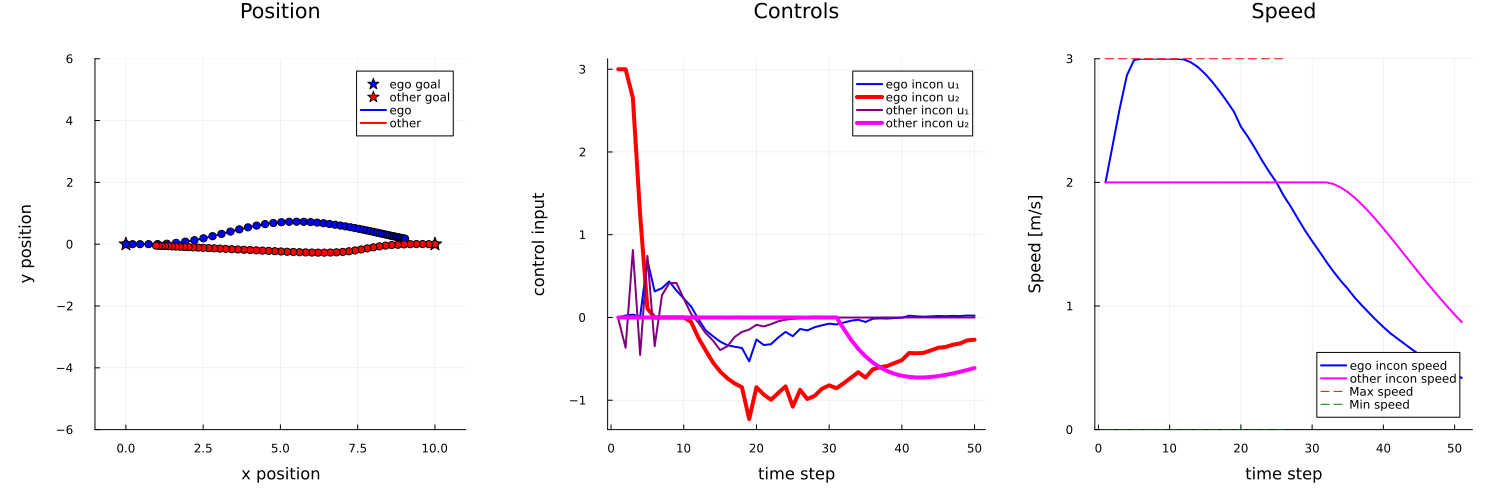

In [60]:
plot_solve_solution(sim_data)

# Experimentation Code

In [ ]:
# for experiment in experiments
#     set up problem. Assign hyperparameters. Cycle through hps for each experiment
#     (markup, collision slack, trust region weights, incon weights, collision radius, incon ratio)
#     for opt_param in opt_params
#         assign new opt_params to the problem.
#         (initial states, goal states)
#         register the InteractionPlanner
#         run simulation
#         store data into dictionary w/ with key=run_number
#         (store: hps, opt_params, and paths) -- enough data to recreate the problem and plot Base.load_path_setup_code
#         delete interaction planner before cycling through the loop.
#     end
# end

In [ ]:
using ProgressBars

In [ ]:
# setting up the problem to be deep copied for experiments
# this is for experimentation where each agent correctly assumes the policy of the oteher agent

# setting up the robot planner
solver = "ECOS"

# defining initial and final states, these are the only things that will be changed in the opt_param sweeps
robot_initial_state = [0.; 0.; 0.; 2.]
robot_goal_state = [10.; 0.; 0.; 2.]
human_initial_state = [10.; 0.; pi; 2.]
human_goal_state = [0.; 0.; pi; 2.]

# defining the planning horizon and dt
time_horizon = 25
dt = 0.1

# some agent specific parametes
velocity_max_robot = 3.0
velocity_max_human = 3.

human = DynamicallyExtendedUnicycle(dt, velocity_max_human, [1., 3.])

Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])
markup = 1.1
collision_slack = 250.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.1]
collision_radius = 1.
inconvenience_ratio = 0.2

human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0

robot = DynamicallyExtendedUnicycle(dt, velocity_max_robot, [1., 3.])

Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)

# defining the robot ip
robot_ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
        
# defining the human ip, it will be the exact same as the robot ip, just in a different order

human_ip = InteractionPlanner(human_hps, 
                        robot_hps,
                        human_initial_state,
                        robot_initial_state,
                        human_goal_state,
                        robot_goal_state,
                        solver)

### Mohr's Circle-ish Implementation 

In [ ]:
include("experiments.jl")

In [ ]:
test_human = DynamicallyExtendedUnicycle(dt, velocity_max_human, [1., 1.5])

In [ ]:
robot_states = mohrs_circle_states(test_human, [0., 0., 0., 0.], [10., 0., 0., 0.], pi / 6);

In [ ]:
human_states = [([10., 0., pi, 0.], [0., 0., pi, 0.])]

### Simulation Code

In [ ]:
sim_test = simulation_sweep(robot_ip, human_ip, robot_states, human_states)

In [ ]:
plot_solve_solution(sim_test["Run 5"], pos_xlims=[-1, 11], pos_ylims=[-6, 6])

# Data Metrics

In [ ]:
dt = sim_data.sim_params.ego_planner_params.hps.dynamics.dt
sim_horizon = length(sim_data.ego_states[:, 1])

ego_dyn = sim_data.sim_params.ego_planner_params.hps.dynamics
ego_xs = sim_data.ego_states
ego_us = sim_data.ego_controls
ego_goal = sim_data.sim_params.ego_planner_params.opt_params.goal_state

other_dyn = sim_data.sim_params.other_planner_params.hps.dynamics
other_xs = sim_data.other_states
other_us = sim_data.other_controls
other_goal = sim_data.sim_params.other_planner_params.opt_params.goal_state


In [ ]:
# Avg energy
avg_energy = sum(norm(ego_us[t, :]) * dt for t in 1:50) / sim_horizon

In [ ]:
# Path Irregularity Index (PI)
ego_velocities = get_velocity(ego_dyn, matrix_to_vector_of_vectors(ego_xs)[1:end-1], matrix_to_vector_of_vectors(ego_us))
other_velocities = get_velocity(other_dyn, matrix_to_vector_of_vectors(other_xs)[1:end-1], matrix_to_vector_of_vectors(other_us))

In [ ]:
ego_PI = sum(acos(dot(ego_velocities[i][:], ego_goal[1:2] - ego_xs[i, 1:2]) / (norm(ego_velocities[i][:]) * norm(ego_goal[1:2] - ego_xs[i, 1:2]))) for i in 1:sim_horizon-1)
other_PI = sum(acos(dot(other_velocities[i][:], other_goal[1:2] - other_xs[i, 1:2]) / (norm(other_velocities[i][:]) * norm(other_goal[1:2] - other_xs[i, 1:2]))) for i in 1:sim_horizon-1)

In [ ]:
# Average acceleration per segment
i = 37
ego_a = (norm(ego_velocities[i]) - norm(ego_velocities[i-1])) / dt

In [ ]:
ego_a = abs(sum((norm(ego_velocities[i]) - norm(ego_velocities[i-1])) / dt for i in 2:sim_horizon-1) / (sim_horizon - 1))

In [ ]:
ego_tnm = 0.0
for i in 2:sim_horizon
    if norm(ego_xs[i, 1:2] - ego_xs[i-1, 1:2]) / dt < 0.1
        ego_tnm += dt
    end
end

In [ ]:
# Path efficiency
ego_PE = sum(norm(ego_xs[i, 1:2] - ego_xs[i-1, 1:2]) for i in 2:sim_horizon) / norm(ego_goal[1:2] - ego_xs[1, 1:2])
other_PE = sum(norm(other_xs[i, 1:2] - other_xs[i-1, 1:2]) for i in 2:sim_horizon) / norm(other_goal[1:2] - other_xs[1, 1:2])

In [ ]:
distances = [norm(ego_xs[i, 1:2] - other_xs[i, 1:2]) for i in 1:sim_horizon]

In [ ]:
relative_v = [distances[i] - distances[i-1] for i in 2:sim_horizon]

In [ ]:
# Sample vector
vector = [2, -3, 5, 0, 1, -4, 6]

# Filter out non-positive values and then find the index of the minimum
min_positive = minimum(filter(x -> x > 0, relative_v))
index_of_min_positive = argmin(abs.(relative_v .- min_positive))

println("Minimum positive value:", min_positive)
println("Index of minimum positive value:", index_of_min_positive)